In [1]:
from lib.training import train, eval
from lib.data import get_data_chest_x_ray_image
from lib.utils import get_device
from torch import nn 
import torch
import torch.optim as opt
import pandas as pd

/home/matheusmartin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
class ExperimentConfig:
    def __init__(self, name, model_fn, loss_fn, optimizer_fn, class_map=None, idx_to_class=None):
        self.name = name
        self.model_fn = model_fn
        self.loss_fn = loss_fn
        self.optimizer_fn = optimizer_fn
        self.class_map = class_map
        self.idx_to_class = idx_to_class

In [38]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
from lib.data import TransformDataset
from lib.utils import plot_evolution, plot_confusion_matrix

def generate_stat_dataframe(path_to_history : dict, save_name, device):
    import torch
    from collections import defaultdict
    import pandas as pd
    
    cp_paths = os.listdir(path_to_history)
    cp_paths = [os.path.join(path_to_history, x) for x in cp_paths if ('best' not in x) and ('.parquet' not in x)] ## filtering desirable file type
    cp_paths = [x for x in cp_paths if os.path.isfile(x)] ## filtering just files

    df_save_path = os.path.join(path_to_history, f'{save_name}.parquet')
    df_data = defaultdict(list)

    for cp_path in cp_paths: 
        checkpoint = torch.load(cp_path, weights_only=False, map_location=device)
        history = checkpoint['metadata']['history']
        
        prefix, ext = os.path.splitext(cp_path)
        fold_number = int(prefix.split('fold=')[-1])
        
        columns = list(history.keys())
        for c in columns: df_data[c].extend(history[c])
        
        repeated_fold_list = [fold_number]*(len(history[columns[0]]))
        df_data['fold'].extend(repeated_fold_list)
        
    results_df = pd.DataFrame(data=df_data)
    results_df.to_parquet(path=df_save_path, compression='gzip')
    
    return results_df

def prepare_dataloaders(*datasets, batch_size=64, shuffle=True):
    num_workers = max(1, os.cpu_count() - 1)
    dataloader_list = []
    for dataset in datasets:
        new_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=True
        )
        dataloader_list.append(new_dataloader)
    return dataloader_list

def get_my_metrics(device, n_classes=2, task='multiclass'):
    import torchmetrics
    from lib.metrics import MetricCollection

    metrics = MetricCollection(device=device)

    if (task == 'multiclass') or (task == 'binary'):
        metrics.register('accuracy', torchmetrics.Accuracy(task='multiclass', num_classes=n_classes))
        metrics.register('precision', torchmetrics.Precision(task='multiclass', num_classes=n_classes, average='macro'))
        metrics.register('recall', torchmetrics.Recall(task='multiclass', num_classes=n_classes, average='macro'))
        metrics.register('f1_score', torchmetrics.F1Score(task='multiclass', num_classes=n_classes, average='macro'))

    elif task == 'multilabel':
        metrics.register('accuracy', torchmetrics.Accuracy(task='multilabel', num_labels=n_classes))
        metrics.register('precision', torchmetrics.Precision(task='multilabel', num_labels=n_classes, average='macro'))
        metrics.register('recall', torchmetrics.Recall(task='multilabel', num_labels=n_classes, average='macro'))
        metrics.register('f1_score', torchmetrics.F1Score(task='multilabel', num_labels=n_classes, average='macro'))

    else:
        raise ValueError(f"Task {task} does not exist. Use 'binary', 'multiclass' or 'multilabel'.")

    return metrics

### target_class --> 0, others --> 1
def get_binary_class_mapping_dict(old_id2class_map : dict, target_label):
    old_idx_to_new_idx = {k:(1 if target_label!= v else 0) for k,v in old_id2class_map.items()}
    new_idx_to_class = {0: target_label, 1 : f'not-{target_label}'}
    return old_idx_to_new_idx, new_idx_to_class
    

def generate_fold_plots(results_df: pd.DataFrame, target_columns, title, save_path=None, highlight=None):
    
    for fold in results_df['fold'].unique().tolist():
        fold_slice = results_df[results_df['fold'] == fold].reset_index(drop=True)
        column_values = [fold_slice[tc].tolist() for tc in target_columns]
        
        best_epochs = None
        if highlight is not None:      
            best_epochs = []
            for tc in target_columns:
                if highlight == 'max':
                    best_epochs.append(fold_slice[tc].values.argmax() + 1)
                elif highlight == 'min':
                    best_epochs.append(fold_slice[tc].values.argmin() + 1)
        
        if save_path is not None:
            os.makedirs(save_path, exist_ok=True)
            save_full_path = os.path.join(save_path, f'{title}_fold={fold}.png')
        else:
            save_full_path = None
        
        plot_evolution(
            y_values=column_values, 
            y_labels=target_columns, 
            title=title,
            xlabel='Epochs', 
            ylabel='Values', 
            path=save_full_path, 
            #vlines=best_epochs
        )    
        
    return 

def load_only_model_state(checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=device)
    return checkpoint['model_state_dict']

def experiment(config : ExperimentConfig, data_dict, device, metrics, freeze=False, epochs=30, warmup=5, patience=10, mode='train', best_by='val_f1_score', best_by_mode='max'):
    
    save_path = f'experiments/{config.name}_folder'
    images_path = os.path.join(save_path, 'images/')
    
    os.makedirs(save_path, exist_ok=True)   
    os.makedirs(images_path, exist_ok=True)
    
    if mode == 'train' or mode == 'train+results':
        
        folds = data_dict['folds']
        base_dataset = data_dict['base_dataset']
        train_transform = data_dict['train_transform']
        test_transform = data_dict['test_transform']
        
        for fold_idx, (train_idx, val_idx) in enumerate(folds):
            print(f"\n--- Fold {fold_idx+1} ---")
            
            model = config.model_fn().to(device=device)
            
            if freeze: model.freeze()
            else : model.unfreeze()

            optimizer = config.optimizer_fn(model.parameters())
            loss_fn = config.loss_fn()
            
            train_subset = Subset(base_dataset, train_idx)
            val_subset = Subset(base_dataset, val_idx)

            train_dataset = TransformDataset(train_subset, train_transform, class_map=config.class_map)
            val_dataset = TransformDataset(val_subset, test_transform, class_map=config.class_map)
            
            train_dataloader, val_dataloader = prepare_dataloaders(train_dataset, val_dataset)
            
            save_name = f'{config.name}_fold={fold_idx+1}.pt'
            
            history, model = train(
                model, train_dataloader, val_dataloader,
                loss_fn, optimizer,
                save_path=save_path, save_name=save_name,
                device=device, metrics=metrics, verbose=True,
                epochs=epochs, warmup=warmup, patience=patience,
            )
            
    elif mode == 'results' or mode == 'train+results':
        from sklearn.metrics import classification_report
        
        print('Generating results only ...')
        ## getting best fold model
        results_df = generate_stat_dataframe(save_path, f'{config.name}_results', device)  
        
        generate_fold_plots(results_df, ['val_loss', 'train_loss'], 'Loss Evolution Plot', save_path=images_path, highlight='min')
         
        if best_by_mode == "max":
            best_idx = results_df[best_by].idxmax()
        elif best_by_mode == 'min':
            best_idx = results_df[best_by].idxmin()
        else:
            raise ValueError(f'best_by_mode `{best_by_mode}` is not valid')
        selected_fold = results_df.loc[best_idx, 'fold']
        
        print(f'Best model generated at folder `{selected_fold}`')
        ## loading best model of the selected fold
        fold_model_path = os.path.join(save_path, f'best_{config.name}_fold={selected_fold}.pt')
        print(f'Loading model `{fold_model_path}`')
        
        model_state = load_only_model_state(fold_model_path, device)       
        model = config.model_fn().to(device=device)
        model.load_state_dict(model_state)
        
        ### test dataset already has the transformations applied
        test_dataset = TransformDataset(data_dict['test_dataset']  , transform=None, class_map=config.class_map)
        
        test_dataloader = prepare_dataloaders(test_dataset)[0] ## returns a list
        
        print('Evaluating on test dataset...')
        y_true, y_pred = eval(model, test_dataloader, device, task='multiclass')
        
        print("Classification Report:")
        ### check if a custom map was passed into config
        idx_to_class_map = config.idx_to_class if config.idx_to_class else data_dict['idx_to_class']
    
        target_names = [idx_to_class_map[i] for i in sorted(idx_to_class_map.keys())]
        report = classification_report(y_true, y_pred, target_names=target_names)
        print(report)
    
        print('Confusion Matrix:') 
        cm_save_path = os.path.join(images_path, f'confusion_matrix.png')
        plot_confusion_matrix(y_true, y_pred, class_map=idx_to_class_map, save_path=cm_save_path)
        
    else:
        raise ValueError(f'mode `{mode}` is not valid')

In [4]:
data_dict = get_data_chest_x_ray_image(img_size=(224, 224), kfold=5)    

In [5]:
device = get_device()

In [41]:
from lib.models import MyResnet, MyMobileNet, MyDenseNet, MyViT

n_classes = len(data_dict['classes'])
metrics = get_my_metrics(device, n_classes)

In [42]:
metrics = get_my_metrics(device, n_classes=n_classes, task='multiclass')
binary_metrics = get_my_metrics(device, n_classes=2, task='binary')
old_idx_to_new_idx, new_idx_to_class = get_binary_class_mapping_dict(data_dict['idx_to_class'], target_label='PNEUMONIA')

In [40]:
print(data_dict['idx_to_class'])
print(old_idx_to_new_idx, new_idx_to_class)

{0: 'COVID19', 1: 'NORMAL', 2: 'PNEUMONIA'}
{0: 1, 1: 1, 2: 0} {0: 'PNEUMONIA', 1: 'not-PNEUMONIA'}


In [ ]:
resnet18_binary_config = ExperimentConfig(
    name="resnet18_binary",
    model_fn=lambda: MyResnet(resnet_version='resnet18', n_classes=2),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    class_map=old_idx_to_new_idx,
    idx_to_class=new_idx_to_class,
    )      
experiment(resnet18_binary_config, data_dict, device, binary_metrics, freeze=False, epochs=50, mode='train+results')

del resnet18_binary_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Generating results only ...
Best model generated at folder `4`
Loading model `experiments/resnet18_freeze_binary_folder/best_resnet18_freeze_binary_fold=4.pt`
Evaluating on test dataset...


Classification Report:
               precision    recall  f1-score   support

    PNEUMONIA       0.94      0.93      0.94       855
not-PNEUMONIA       0.87      0.88      0.87       433

     accuracy                           0.91      1288
    macro avg       0.90      0.91      0.90      1288
 weighted avg       0.91      0.91      0.91      1288

Confusion Matrix:


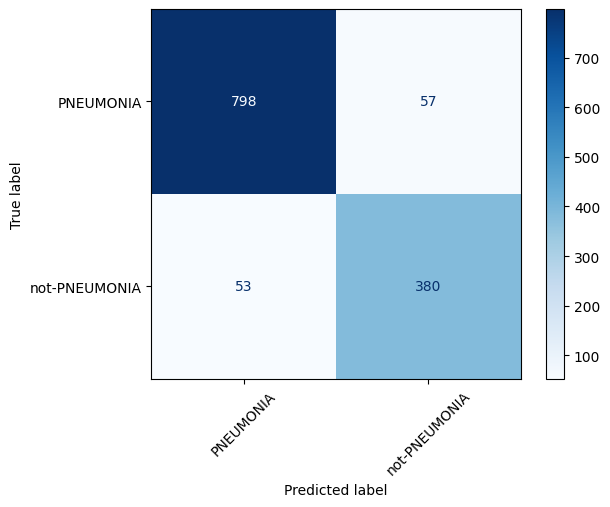

In [51]:
## resnet18 congelada
resnet18_freeze_binary_config = ExperimentConfig(
    name="resnet18_freeze_binary",
    model_fn=lambda: MyResnet(resnet_version='resnet18', n_classes=2),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    class_map=old_idx_to_new_idx,
    idx_to_class=new_idx_to_class,
    )      
experiment(resnet18_freeze_binary_config, data_dict, device, binary_metrics, freeze=True, epochs=50, mode='results')

del resnet18_freeze_binary_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Generating results only ...
Best model generated at folder `3`
Loading model `experiments/resnet34_binary_folder/best_resnet34_binary_fold=3.pt`
Evaluating on test dataset...


Classification Report:
               precision    recall  f1-score   support

    PNEUMONIA       0.98      0.98      0.98       855
not-PNEUMONIA       0.96      0.95      0.95       433

     accuracy                           0.97      1288
    macro avg       0.97      0.97      0.97      1288
 weighted avg       0.97      0.97      0.97      1288

Confusion Matrix:


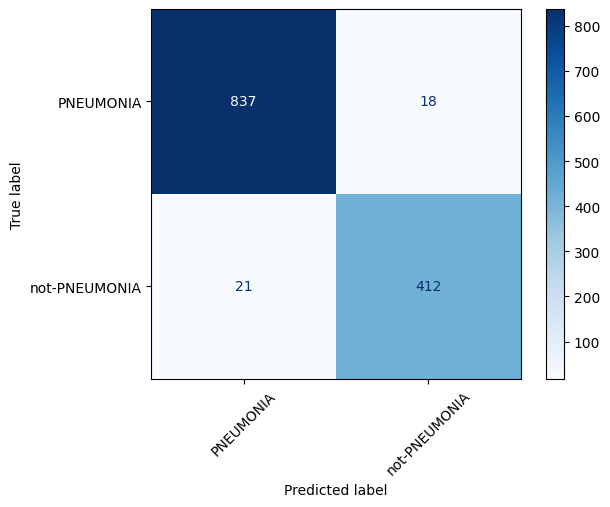

In [52]:
resnet34_binary_config = ExperimentConfig(
    name="resnet34_binary",
    model_fn=lambda: MyResnet(resnet_version='resnet34', n_classes=2),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    class_map=old_idx_to_new_idx,
    idx_to_class=new_idx_to_class,
    )      
experiment(resnet34_binary_config, data_dict, device, binary_metrics, freeze=False, epochs=50, mode='results')

del resnet34_binary_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Generating results only ...
Best model generated at folder `4`
Loading model `experiments/resnet34_freeze_binary_folder/best_resnet34_freeze_binary_fold=4.pt`
Evaluating on test dataset...


Classification Report:
               precision    recall  f1-score   support

    PNEUMONIA       0.96      0.93      0.94       855
not-PNEUMONIA       0.87      0.92      0.89       433

     accuracy                           0.93      1288
    macro avg       0.91      0.92      0.92      1288
 weighted avg       0.93      0.93      0.93      1288

Confusion Matrix:


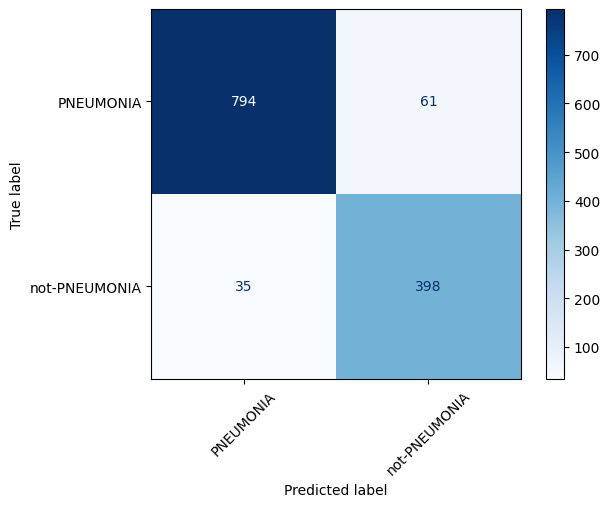

In [53]:
## resnet34 congelada
resnet34_freeze_binary_config = ExperimentConfig(
    name="resnet34_freeze_binary",
    model_fn=lambda: MyResnet(resnet_version='resnet34', n_classes=2),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    class_map=old_idx_to_new_idx,
    idx_to_class=new_idx_to_class,
    )      
experiment(resnet34_freeze_binary_config, data_dict, device, binary_metrics, freeze=True, epochs=50, mode='results')

del resnet34_freeze_binary_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Generating results only ...
Best model generated at folder `3`
Loading model `experiments/mobilenet_v2_binary_folder/best_mobilenet_v2_binary_fold=3.pt`
Evaluating on test dataset...


Classification Report:
               precision    recall  f1-score   support

    PNEUMONIA       0.97      0.98      0.98       855
not-PNEUMONIA       0.96      0.95      0.96       433

     accuracy                           0.97      1288
    macro avg       0.97      0.96      0.97      1288
 weighted avg       0.97      0.97      0.97      1288

Confusion Matrix:


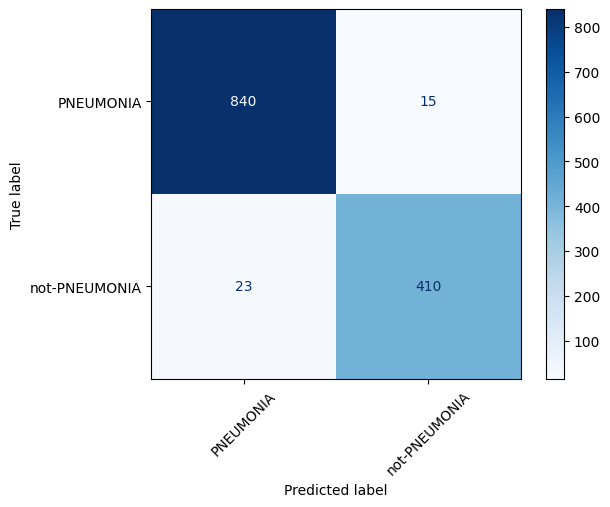

In [55]:
mobilenet_v2_binary_config = ExperimentConfig(
    name="mobilenet_v2_binary",
    model_fn=lambda: MyMobileNet(mobilenet_version='mobilenet_v2', n_classes=2),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    class_map=old_idx_to_new_idx,
    idx_to_class=new_idx_to_class,
    )      
experiment(mobilenet_v2_binary_config, data_dict, device, binary_metrics, freeze=False, epochs=50, mode='results')

del mobilenet_v2_binary_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Generating results only ...
Best model generated at folder `2`
Loading model `experiments/mobilenet_v3_large_binary_folder/best_mobilenet_v3_large_binary_fold=2.pt`
Evaluating on test dataset...


Classification Report:
               precision    recall  f1-score   support

    PNEUMONIA       0.98      0.97      0.98       855
not-PNEUMONIA       0.94      0.96      0.95       433

     accuracy                           0.97      1288
    macro avg       0.96      0.97      0.96      1288
 weighted avg       0.97      0.97      0.97      1288

Confusion Matrix:


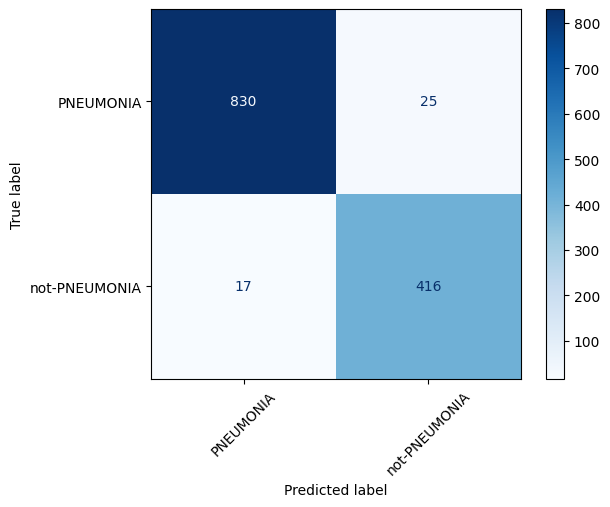

In [56]:
mobilenet_v3_large_binary_config = ExperimentConfig(
    name="mobilenet_v3_large_binary",
    model_fn=lambda: MyMobileNet(mobilenet_version='mobilenet_v3_large', n_classes=2),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    class_map=old_idx_to_new_idx,
    idx_to_class=new_idx_to_class,
    )      
experiment(mobilenet_v3_large_binary_config, data_dict, device, binary_metrics, freeze=False, epochs=50, mode='results')

del mobilenet_v3_large_binary_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Generating results only ...
Best model generated at folder `2`
Loading model `experiments/densenet121_binary_folder/best_densenet121_binary_fold=2.pt`
Evaluating on test dataset...


Classification Report:
               precision    recall  f1-score   support

    PNEUMONIA       0.95      0.97      0.96       855
not-PNEUMONIA       0.94      0.90      0.92       433

     accuracy                           0.95      1288
    macro avg       0.95      0.94      0.94      1288
 weighted avg       0.95      0.95      0.95      1288

Confusion Matrix:


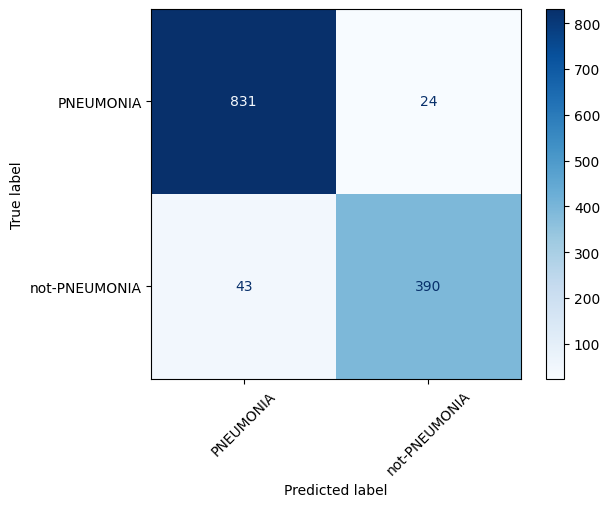

In [57]:
densenet121_binary_config = ExperimentConfig(
    name="densenet121_binary",
    model_fn=lambda: MyDenseNet(densenet_version='densenet121', n_classes=2),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    class_map=old_idx_to_new_idx,
    idx_to_class=new_idx_to_class,
    )      
experiment(densenet121_binary_config, data_dict, device, binary_metrics, freeze=False, epochs=50, mode='results')

del densenet121_binary_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Generating results only ...
Best model generated at folder `2`
Loading model `experiments/densenet161_binary_folder/best_densenet161_binary_fold=2.pt`
Evaluating on test dataset...


Classification Report:
               precision    recall  f1-score   support

    PNEUMONIA       0.96      0.95      0.95       855
not-PNEUMONIA       0.90      0.92      0.91       433

     accuracy                           0.94      1288
    macro avg       0.93      0.93      0.93      1288
 weighted avg       0.94      0.94      0.94      1288

Confusion Matrix:


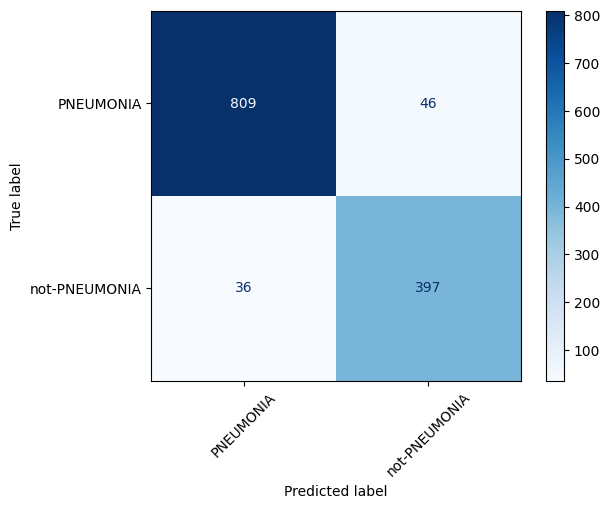

In [58]:
densenet161_binary_config = ExperimentConfig(
    name="densenet161_binary",
    model_fn=lambda: MyDenseNet(densenet_version='densenet161', n_classes=2),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    class_map=old_idx_to_new_idx,
    idx_to_class=new_idx_to_class,
    )      
experiment(densenet161_binary_config, data_dict, device, binary_metrics, freeze=False, epochs=50, mode='results')

del densenet161_binary_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Generating results only ...
Best model generated at folder `3`
Loading model `experiments/vit_b_16_binary_folder/best_vit_b_16_binary_fold=3.pt`
Evaluating on test dataset...


Classification Report:
               precision    recall  f1-score   support

    PNEUMONIA       0.94      0.96      0.95       855
not-PNEUMONIA       0.92      0.87      0.89       433

     accuracy                           0.93      1288
    macro avg       0.93      0.92      0.92      1288
 weighted avg       0.93      0.93      0.93      1288

Confusion Matrix:


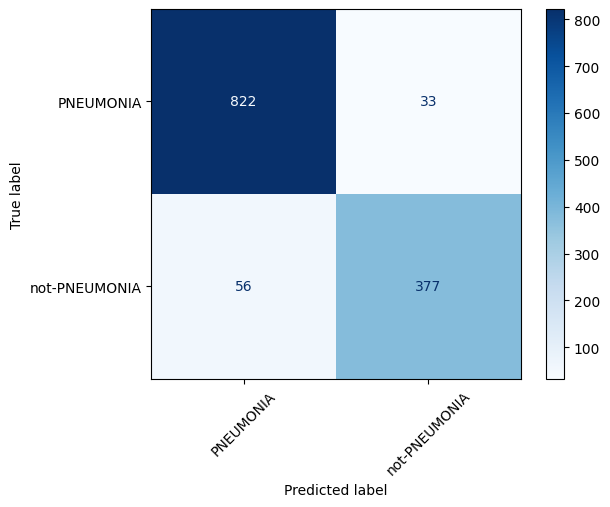

In [59]:
vit_b_16_binary_config = ExperimentConfig(
    name="vit_b_16_binary",
    model_fn=lambda: MyViT(vit_version='vit_b_16', n_classes=2),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    class_map=old_idx_to_new_idx,
    idx_to_class=new_idx_to_class,
    )      
experiment(vit_b_16_binary_config, data_dict, device, binary_metrics, freeze=False, epochs=100, mode='results')

del vit_b_16_binary_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [31]:
def friedman_test_and_posthoc_nemenyi(experimentpath_modelname_list: list[str], target_column='val_f1_score', alpha=0.05):
    from scipy.stats import friedmanchisquare
    from scikit_posthocs import posthoc_nemenyi_friedman
    
    friedman_data_df = pd.DataFrame()
    
    model_name_list = [] ## to fix order
    
    for experiment_path, model_name in experimentpath_modelname_list:
        _dir = os.listdir(experiment_path)
        result_df_path = [x for x in _dir if '.parquet' in x][-1]
        result_df_path = os.path.join(experiment_path, result_df_path)
        
        result_df = pd.read_parquet(result_df_path)
        result_df_max = result_df.groupby('fold').max().reset_index()
        friedman_data_df[model_name] = result_df_max[target_column]
        
        model_name_list.append(model_name)
    
    friedman_statistic, p_value = friedmanchisquare(*[friedman_data_df[m_name] for m_name in model_name_list])
    
    if p_value < alpha:
        print(f"friedman p_value=({p_value:.4f}) is lower than alpha={alpha}.")
        print("Doing Posthoc Nemenyi Test...")
        print("-" * 50)

        # Executando o teste post-hoc de Nemenyi
        # A função espera os dados em um formato diferente, por isso usamos o .T (transposta)
        nemenyi_results = posthoc_nemenyi_friedman(friedman_data_df)

        print(nemenyi_results.round(4))
        print("-" * 50)
        nemenyi_results = (nemenyi_results < alpha).astype(int)    
        print(nemenyi_results)

    else:
        print(f"friedman p_value=({p_value:.4f}) is bigger than alpha={alpha}.")
        print("There is no statistical relevant difference between the models.")

    return    


In [32]:
experimentpath_modelname_list = [
    ('experiments/resnet18_folder/', 'resnet18'),
    ('experiments/resnet34_folder/', 'resnet34'),
    ('experiments/mobilenet_v2_folder/', 'mobilenet_v2'),
    ('experiments/mobilenet_v3_large_folder/', 'mobilenet_v3_large'),
    ('experiments/densenet121_folder/', 'densenet121'),
    ('experiments/densenet161_folder/', 'densenet161'),
    ('experiments/resnet18_freeze_folder/', 'resnet18_freeze'),
    ('experiments/resnet34_freeze_folder/', 'resnet34_freeze'),
    ('experiments/vit_b_16_folder/', 'vit_b_16'),
]

friedman_test_and_posthoc_nemenyi(experimentpath_modelname_list, alpha=0.05)

friedman p_value=(0.0000) is lower than alpha=0.05.
Doing Posthoc Nemenyi Test...
--------------------------------------------------
                    resnet18  resnet34  mobilenet_v2  mobilenet_v3_large  \
resnet18              1.0000    1.0000        0.9036              0.9989   
resnet34              1.0000    1.0000        0.9656              0.9999   
mobilenet_v2          0.9036    0.9656        1.0000              0.9989   
mobilenet_v3_large    0.9989    0.9999        0.9989              1.0000   
densenet121           0.9656    0.9036        0.2126              0.6501   
densenet161           0.1639    0.0918        0.0017              0.0230   
resnet18_freeze       0.7267    0.5695        0.0477              0.2702   
resnet34_freeze       0.9036    0.7960        0.1239              0.4882   
vit_b_16              0.1639    0.0918        0.0017              0.0230   

                    densenet121  densenet161  resnet18_freeze  \
resnet18                 0.9656       0.1

In [ ]:
## mobile_v2 --> dense161, resnet18_freeze
## dense161 --> mobilenet_v3_large
## vit --> mobilev2 e movibilev3